In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize, imread

import os

%matplotlib inline

<h3> 전처리 </h3>

In [2]:
cur_dir = os.getcwd()
data_dir = os.listdir("./train")
data_dir

['Cleavers', 'Common Chickweed']

In [3]:
def image_road(data_dir):
    img_matrix = []
    label = []
    index = 0
    
    for data_label in data_dir:
        category_list = os.listdir(cur_dir + "/train/" + data_label)
        for data in category_list:
            img = imread(cur_dir + "/train/" + data_label + "/" + data)
            resize_img = imresize(img, [256,256,3])
            img_matrix.append(resize_img)
            label.append(index)
            #label = [0, 0, ... , 1, 1, 1]
            #분류니까 labeld을 one hot으로 바꾸는게 편해
        index += 1
    return img_matrix, label

In [4]:
img_matrix , label = image_road(data_dir)

In [8]:
y_data = np.eye(len(data_dir))[label]

In [9]:
# np.array(img_matrix) / 255

Image size : (898, 256, 256, 3)


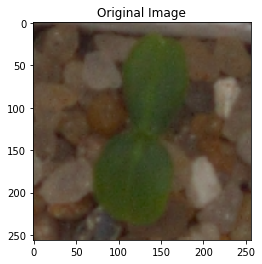

In [10]:
plt.imshow(img_matrix[0])
plt.title("Original Image")
print("Image size :", np.shape(img_matrix))

이미지에서 돌이 방해요소니까 돌을 제거해야해<br>
초록색인거랑 아닌거를 구분해서 아닌거는 제거<br><br>
r = img[:, :, :, 0] <br>
g = img[:, :, :, 1] <br>
b = img[:, :, :, 2]

In [11]:
img = np.array(img_matrix)/255
print("change the range of image : \n",img[0,0:3,0:3,0])
print(np.shape(img))

change the range of image : 
 [[ 0.3254902   0.3254902   0.3254902 ]
 [ 0.31372549  0.31372549  0.31764706]
 [ 0.29803922  0.29803922  0.30196078]]
(898, 256, 256, 3)


In [12]:
for i in range(len(img)):
    row_img = img[i]
    red = row_img[:, :, 0]
    green = row_img[:, :, 1]
    blue = row_img[:, :, 2]
    
    red_reshape = np.reshape(red, -1)
    green_reshape = np.reshape(green, -1)
    blue_reshape = np.reshape(blue, -1)
    
    for index, value in enumerate(zip(red_reshape, green_reshape, blue_reshape)):
        #green 비교
        if value[1] < 0.20:
            img[i, index//256, index%256, :] = 0
        elif value[0] > 0.30:
            img[i, index//256, index%256, :] = 0
        elif value[2] > 0.20:
            img[i, index//256, index%256, :] = 0    

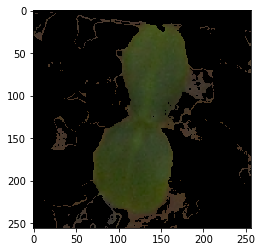

In [13]:
plt.imshow(img[0])

In [14]:
randidx = np.random.randint(len(img), size=len(img))
shuffle_x = img[randidx, :]
shuffle_y = y_data[randidx, :]

In [15]:
split_value = int(len(img)*0.8)
train_x = shuffle_x[:split_value]
train_y = shuffle_y[:split_value]
test_x = shuffle_x[split_value:]
test_y = shuffle_y[split_value:]

<h3>파라미터 설정</h3>

In [16]:
x = tf.placeholder(tf.float32, [None, 256, 256, 3])
x_img = tf.reshape(x, [-1, 256*256*3])
y = tf.placeholder(tf.float32, [None, 2])

batch = 64             #img에서 batch는 거의 64의 배수
learning_rate = 0.01
epochs = 5

<h3>모델 bulid</h3>

In [17]:
w1 = tf.get_variable(name='weight1', shape=[256*256*3, 256], 
                     initializer=tf.random_normal_initializer())
b1 = tf.get_variable(name='bias1', shape=[256], 
                     initializer=tf.zeros_initializer())
#bias를 zeros_initializer를 쓰면 학습이 더 잘돼?
#쉬운거는 보편적으로 bias를 zero로 initialize해
layer1 = tf.nn.bias_add(tf.matmul(x_img, w1), b1)
layer1 = tf.nn.relu(layer1)

w2 = tf.get_variable(name='weight2', shape=[256, 512], 
                     initializer=tf.random_normal_initializer())
b2 = tf.get_variable(name='bias2', shape=[512], 
                     initializer=tf.zeros_initializer())
layer2 = tf.nn.bias_add(tf.matmul(layer1, w2), b2)
layer2 = tf.nn.relu(layer2)

w3 = tf.get_variable(name='weight3', shape=[512, 2], 
                     initializer=tf.random_normal_initializer())
b3 = tf.get_variable(name='bias3', shape=[2], 
                     initializer=tf.zeros_initializer())
layer3 = tf.nn.bias_add(tf.matmul(layer2, w3), b3)

<h3>Loss</h3>

In [ ]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=layer3, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(layer3, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        avg_cost = 0
        total_batch = int(len(train_x)/batch)
        for step in range(total_batch):
            randidx = np.random.randint(len(train_x), size=batch)
            batch_x = train_x[randidx, :]
            batch_y = train_y[randidx, :]
            feed_dict = {x: batch_x, y: batch_y}
            c, _ = sess.run([loss, optimizer], feed_dict = feed_dict)
            avg_cost += c / total_batch
        if epoch % 5 == 0:
            print("Cost: ", avg_cost)
            print("Accuracy: ", sess.run(accuracy, feed_dict = {x:test_x, y: test_y}))
            

Cost:  24379.2374822
Accuracy:  0.711111
